In [1]:
import glob
import time
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import matplotlib as mpl
import numpy as np


urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/courierprime/CourierPrime-Regular.ttf",
    "CourierPrime-Regular.ttf",
)
fe = mpl.font_manager.FontEntry(fname="CourierPrime-Regular.ttf", name="courierprime")
mpl.font_manager.fontManager.ttflist.append(fe)
color_cycle = ["#444444", "#1BBC9B", "#a895bb", "#F06060", "#F3B562", "#80cedb"]
mpl.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler(color=color_cycle),
        "font.family": fe.name,
        "font.size": 12,
        "figure.figsize": (4.5, 4.5 / 1.3),
        "figure.dpi": 100,
        "ytick.left": True,
        "xtick.bottom": True,
        "image.cmap": "gist_yarg",
        "lines.markersize": 1
    }
)

## Load Prompts

In [2]:
topic_categories = ['md', 'spectroscopy', 'bio', 'qm', 'sim', 'cheminf', 'genchem', 'thermo', 'stats', 'plot']
code_categories = ['code', 'human']
lang_categories = ['ch']
keys = ['name', 'language', 'context']

In [3]:
data = None
valid_files = []
def insert_row(r, data):
    if data is None:
        return {k: [v] for k,v in r.items()}
    return  {k: v + [r[k]] for k,v in data.items()}
for fn in glob.glob('../data/**/*.yml'):
    with open(fn, 'r') as f:
        d = yaml.safe_load(f)
        # slice        
        cat_str = d['categories'] 
        d = {k: d[k] for k in keys}
        # duplicate for categories
        tcs = [c for c in topic_categories if c in cat_str]
        ccs = [c for c in code_categories if c in cat_str]
        lcs = [c for c in lang_categories if c in cat_str]
        if len(lcs) == 0:
            lcs = ['en']
        if len(tcs) > 0:
            valid_files.append(fn)
        for tc in tcs:
            for cc in ccs:
                for lc in lcs:
                    d.update({'topic': tc, 'type': cc, 'natlang': lc})                    
                    data = insert_row(d, data)
                    
df = pd.DataFrame.from_dict(data)

In [4]:
df[df.type == 'human'].groupby('topic').count()

,name,language,context,type,natlang
topic,,,,,
bio,2,2,2,2,2
md,3,3,3,3,3
plot,10,10,10,10,10
qm,3,3,3,3,3
sim,5,5,5,5,5
spectroscopy,1,1,1,1,1
stats,1,1,1,1,1


In [91]:
df.groupby('topic').count()
print(len(valid_files))
paths = ' '.join(valid_files)
temperatures = [0.05, 0.2, 0.5]
models = ['Salesforce/codegen-350M-mono:local --def-end', 'Salesforce/codegen-2B-mono:local --def-end', 'Salesforce/codegen-6B-mono:local --def-end', 'Salesforce/codegen-16B-mono:local --def-end', 'incoder/facebook/incoder-1B', 'incoder/facebook/incoder-6B', 'openai/code-cushman-001', 'openai/code-davinci-002', 'openai/text-davinci-003']
model_names = ['codegen-350M', 'codegen-2B', 'codegen-6B', 'codegen-16B', 'incoder-1B', 'incoder-6B', 'cushman', 'davinci', 'davinci3']
can_insert = [False, False, False, False, True, True, False, True, True]
ks = [5, 5, 5, 5, 5, 1, 5, 5, 5]
do_compute = [False, False, False, False, False, False, False]

84


## Programmatic Prompts

In [90]:
for d, ins, m, mn, k in zip(do_compute, can_insert, models, model_names, ks):
    if not d:
        continue
    for i,t in enumerate(temperatures):
        out = f'override_{mn}_{i}.csv'
        print(out)
        !nlcc-bench $paths $out --n $k --prompt python --temperature $t --engine $m
        out = f'bench_{mn}_{i}.csv'
        !nlcc-bench $paths $out --n $k --temperature $t --engine $m
        if ins:
            out = f'insert_bench_{mn}_{i}.csv'
            !nlcc-bench $paths $out --n $k --prompt insert --temperature $t --engine $m
        out = f'cheader_bench_{mn}_{i}.csv'
        insert_text = '-insert' if ins else ''
        header = f'header{insert_text}:# MIT License\n\n# Copyright (c) 2022 University of Rochester\n\n'
        !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t --engine $m        
        out = f'lheader_bench_{mn}_{i}.csv'
        header = f'header{insert_text}:# This is written by an expert Python programmer\n\n'
        !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t --engine $m


override_davinci3_0.csv
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7101899835897.279
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radia

name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_3d_sin/plot_3d_sin.yml
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/plot_bar/plot_bar.yml
../data/plot_contour/plot_contour.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_correlation_coefficient/plot_correlation.yml
../data/plo

2021.03.2
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
could not broadcast input array from shape (2,8) into shape (2,)
2021.03.2
array() takes from 1 to 2 positional arguments but 8 were given
2021.03.2
2021.03.2
could not broadcast input array from shape (2,8) into shape (2,)
2021.03.2
could not broadcast input array from shape (2,8) into shape (2,)
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
We

../data/pair_wise/pair_wise.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
atom_pairs must be ndim 2. You supplied 1
1.9.5
atom_pairs must be ndim 2. You supplied 1
1.9.5
atom_pairs must be ndim 2. You supplied 1
1.9.5
atom_pairs must be ndim 2. You supplied 1
1.9.5
atom_pairs must be ndim 2. You supplied 1
../data/pauli_matrices/pauli_matrices.yml
cannot unpack non-iterable NoneType object
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.

'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
invalid syntax (<string>, line 69)
'NoneType' object has no attribute 'text'
../data/bragg/bragg.yml
0.08343008661061502 0.08343008661061502
0.08343008661061502 0.08343008661061502
0.08343008661061502 0.08343008661061502
0.08343008661061502 0.08343008661061502
0.08343008661061502 0.08343008661061502
../data/bravais/bravais.yml
../data/canonicalize/canonicalize.yml
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
../data/carnot_efficiency/carnot_efficiency.yml
../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
'>' not supported between instances of 'method' and '

../data/pauli_matrices/pauli_matrices.yml
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
name 'e' is not defined
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
../data/plot_bar/plot_bar.yml
../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
<string>:21:

'>' not supported between instances of 'method' and 'method'
../data/descriptors/descriptors.yml
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
../data/dou/dou.yml
module 'rdkit.Chem.Descriptors' has no attribute 'NumHalogenAtoms'
module 'rdkit.Chem.Descriptors' has no attribute 'NumHalogenAtoms'
module 'rdkit.Chem.Descriptors' has no attribute 'NumHalogenAtoms'
module 'rdkit.Chem.Descriptors' has no attribute 'NumHalogenAtoms'
module 'rdkit.Chem.Descriptors' has no attribute 'NumHalogenAtoms'
../data/element_mass/element_mass.yml
../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
../data/find_indices/find_indices.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 re

atom_pairs must be ndim 2. You supplied 1
../data/pauli_matrices/pauli_matrices.yml
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
../data/plot_bar/plot_bar.yml
../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
../data/plot_dual_axis/plot_dual

../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
../data/find_indices/find_indices.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/force_const/force_const.yml
../data/freezing_depression/freezing_depression.yml
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find_all'
../data/heating_water/heating_water.yml
../data/hydrophobic_res/hydrophobic_res.yml
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
[0,

Unrecognized marker style '😀'
Unrecognized marker style '😀'
Unrecognized marker style '😀'
Unrecognized marker style '😀'
Unrecognized marker style '😀'
../data/plot_outside_legend/plot_outside_legend.yml
../data/plot_scatter_pointsize/plot_pointsize.yml
../data/plot_sin/plot_sin.yml
../data/plot_sin_polar/plot_sin_polar.yml
<string>:19: UserWarning: Trying to create polar plot on an Axes that does not have a polar projection.
../data/pred-interval/pred_interval.yml
../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
'SimilarityList'
'SimilarityList'
'Response' object has no attribute 'xml'
../data/pyscf_energy/pyscf_energy.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
converged SCF energy = -98.5704897390009
Initialize <pyscf.gto.mole.Mole object at 0x7f3908e87910> in <p

../data/freezing_depression/freezing_depression.yml
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
No module named 'pymatgen'
No module named 'pymatgen'
'NoneType' object is not subscriptable
No module named 'pymatgen'
No module named 'pymatgen'
../data/heating_water/heating_water.yml
../data/hydrophobic_res/hydrophobic_res.yml
name 'md' is not defined
name 'md' is not defined
name 'md' is not defined
name 'md' is not defined
name 'md' is not defined
../data/ideal_gas/ideal_gas.yml
../data/iupac2smiles/iupac2smiles.yml
'2,5,5'
'2,5,5'
'2,5,5'
'2,5,5'
../data/karplus/karplus.yml
../data/kld_loss/kld.yml
../data/langevin/LD.yml
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/least-squares/least-squares.yml
all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 100 and the array at index 1 has size 3
../data/lipinski/lipinski.yml
module 'rdkit.

name 'PDBParser' is not defined
name 'PDBParser' is not defined
name 'Bio' is not defined
name 'PDBParser' is not defined
../data/scaffold/scaffold.yml
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/seq-align/seq-align.yml
invalid syntax (<string>, line 26)
invalid syntax (<string>, line 26)
invalid syntax (<string>, line 26)
EOL while scanning string literal (<string>, line 39)
invalid syntax (<string>, line 33)
../data/seq-trans/seq-trans.yml
sequence item 0: expected str instance, NoneType found
can only concatenate str (not "NoneType") to str
../data/spectral_radius/spectral_r.yml
../data/spectrum-analysis/fit.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/speed_of_sound/speed_of_sound.yml
../data/substructure/substructure.yml
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x

../data/kld_loss/kld.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/langevin/LD.yml
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
../data/least-squares/least-squares.yml
operands could not be broadcast together with shapes (100,3) (100,) 
all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 100
operands could not be broadcast together with shapes (3,) (4,) 
operands could not be broadcast together with shapes (100,) (100,3) 
../data/lipinski/lipinski.yml
2021.03.2
2021.03.2
Hydrogen bond donors: 1
Hydrogen bond acceptors: 5
Molecular weight: 345.4240000

2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/quantile/quantile.yml
../data/random_walk/random_walk.yml
expected x and y to have same length
Timeout
Timeout
expected x and y to have same length
expected x and y to have same length
../data/rm-water/remove-water.yml
1.9.5
1.9.5
1.9.5
1.9.5
1.9.5
../data/rmse/rmse.yml
../data/rms_velocity/rms_velocity.yml
../data/rog/rog.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
1.9.5
1.9.5
1.9.5
1.9.5
../data/rotation/rotation.yml
../data/rotation_higher/rotation_higher.yml
../data/sasa/sasa.yml
1.9.5
1.9.5
1.9.5
1.9.5
1.9.5
../data/scaffold/scaffold.yml
2021.03.2
module 'rdkit.Chem' has no attribute 'MurckoScaffold'
2021.03.2
2021.03.2
module 'rdkit.Chem' has no attribut

../data/kld_loss/kld.yml
../data/langevin/LD.yml
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/least-squares/least-squares.yml
all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 100
operands could not be broadcast together with shapes (100,) (100,3) 
all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 100
all the input array dimensions for the concatenation axis must match exactly, 

../data/rotation/rotation.yml
../data/rotation_higher/rotation_higher.yml
../data/sasa/sasa.yml
../data/scaffold/scaffold.yml
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
../data/seq-align/seq-align.yml
../data/seq-trans/seq-trans.yml
../data/spectral_radius/spectral_r.yml
../data/spectrum-analysis/fit.yml
arrays used as indices must be of integer (or boolean) type
../data/speed_of_sound/speed_of_sound.yml
../data/substructure/substructure.yml
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
F

../data/kld_loss/kld.yml
../data/langevin/LD.yml
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
../data/least-squares/least-squares.yml
operands could not be broadcast together with shapes (3,) (4,) 
all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 100
../data/lipinski/lipinski.yml
../data/mape/mape.yml
../data/mapping_operator/mappin

module 'rdkit.Chem.rdMolHash' has no attribute 'GetMorganFingerprintAsBitVect'
../data/unbdistance/unbdistance.yml
../data/verlet/verlet.yml
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7096741074350.207
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7097548490415.228
spectral radiance = 70

../data/mc_harmonic/mc_harmonic.yml
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
../data/net_charge/net_charge.yml
must be real number, not str
must be real number, not str
must be real number, not str
must be real number, not str
must be real number, not str
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
../data/osmotic_pressure/osmotic_pressure.yml
../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/f

EOL while scanning string literal (<string>, line 38)
'NoneType' object has no attribute 'text'
local variable 'result_url' referenced before assignment
<urlopen error Timeout>
Error message from NCBI: Message ID#24 Error: Failed to read the Blast query: Protein FASTA provided for nucleotide sequence
../data/bragg/bragg.yml
0.08343008661061502 0.08343008661061502
0.08343008661061502 0.08343008661061502
0.08343008661061502 0.08343008661061502
0.08343008661061502 0.08343008661061502
0.08343008661061502 0.08343008661061502
../data/bravais/bravais.yml
47
Error: invalid space group number.
47
../data/canonicalize/canonicalize.yml
['[H]c1nc([H])c([H])c([H])c1[H]', '[H]c1nc([H])c([H])c([H])c1[H]', '[H]C([H])([H])C([H])([H])[H]']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
cannot import name 'GetCanonicalSmiles' from 'rdkit.Chem.rdmolops' (/home/whitead/miniconda3/envs/nlcc/lib/python

name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_correlation_coefficient/plot_correlation.yml
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
Unrecognized marker style '😀'
Unrecognized marker style '😀'
Unrecognized marker style '🤣'
Unrecognized marker style '😀'
Unrecognized marker style '😃'
../data/plot_outside_legend/plot_outside_legend.yml
../data/plot_scatter_pointsize/plot_pointsize.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
../data/plot_sin/plot_sin.yml
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/plot_sin_polar/plot_sin_polar.yml
name 'np' is not defi

../data/compare_electronegativity/compare_electronegativity.yml
'Element' object has no attribute 'en'
'>' not supported between instances of 'method' and 'method'
'Element' object has no attribute 'pauling'
'Element' object has no attribute 'en'
'>' not supported between instances of 'method' and 'method'
../data/descriptors/descriptors.yml
2021.03.2
2021.03.2
[[ 5.8124e+01  1.8064e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00
   0.0000e+00  0.0000e+00]
 [ 4.6069e+01 -1.4000e-03  2.0230e+01  1.0000e+00  1.0000e+00  0.0000e+00
   1.0000e+00  0.0000e+00]
 [ 7.8114e+01  1.6866e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  1.0000e+00]]
2021.03.2
2021.03.2
2021.03.2
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
Weights sum to zero, can't be normalized
<string>:19: RuntimeWarning: divide by zero encountered in tr

../data/mc_harmonic/mc_harmonic.yml
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
'list' object has no attribute 'shape'
'numpy.ndarray' object has no attribute 'index'
'numpy.ndarray' object has no attribute 'index'
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
'list' object has no attribute 'shape'
../data/osmotic_pressure/osmotic_pressure.yml
../data/pair_wise/pair_wise.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('U

atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be ndim 2. You supplied 3
1.9.5
atom_pairs must be ndim 2. You supplied 3
1.9.5
atom_pairs must be ndim 2. You supplied 3
../data/verlet/verlet.yml
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 22257700281363.902
spectral radiance = 7084846043273.869
spectral radiance from codex = 22311140557908.195
spectral radiance = 7

../data/mc_harmonic/mc_harmonic.yml
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
../data/osmotic_pressure/osmotic_pressure.yml
name 'p' is not defined
../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'float' object cannot be interpreted as an integer
name ca is not a valid option. Selection must be one of all, alpha, minimal, heavy, water
atom_pairs must be ndim 2. You supplied 1
compute_distances() got multiple values for argument 'p

invalid syntax (<string>, line 51)
'NoneType' object has no attribute 'lower'
../data/canonicalize/canonicalize.yml
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
../data/carnot_efficiency/carnot_efficiency.yml
../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'Element' object has no attribute 'pauling'
'>' not supported between instances of 'method' and 'method'
../data/descriptors/descriptors.yml
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.27332601

atom_pairs must be ndim 2. You supplied 1
name ca is not a valid option. Selection must be one of all, alpha, minimal, heavy, water
../data/pauli_matrices/pauli_matrices.yml
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
name 'e' is not defined
energy = 4.934802200544679
name 'e' is not defined
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
../data/plot_bar/plot_bar.yml
../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like 

Python argument types in
    rdkit.Chem.rdMolHash.MolHash(Mol)
did not match C++ signature:
    MolHash(RDKit::ROMol mol, RDKit::MolHash::HashFunction func)
module 'rdkit.Chem.Descriptors' has no attribute 'NumHBA'
Python int too large to convert to C long
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
name 'c' is not defined
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
../data/dou/dou.yml
module 'rdkit.Chem.Descriptors' has no attribute 'NumHs'
module 'rdkit.Chem.Descriptors' has no attribute 'CalcCNHHalogen'
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcCNHHal'
module 'rdkit.Chem.Descriptors' has no attribute 'NumHs'
module 'rdkit.Chem.Descriptors' has no attribute 'NumCarbocycles'
../data/element_mass/element_mass.yml
../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
-1.51
../data/find_indices/find_indices.yml
Error: invalid space group num

../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
<string>:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
<string>:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The

In [110]:
merged = None
for i,t in enumerate(temperatures):
    for ins, m, mn in zip(can_insert, models, model_names):
        m = m.split()[0]
        f = f'override_{mn}_{i}.csv'
        try:
            bf = pd.read_csv(f, delim_whitespace=True)    
        except FileNotFoundError as e:
            print('Skipping', f)
            continue
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = 'none'
        if merged is None:
            merged = bf
        else:
            merged = pd.concat((merged, bf))
        f = f'bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        merged = pd.concat((merged, bf))
        if ins:
            f = f'insert_bench_{mn}_{i}.csv'
            bf = pd.read_csv(f, delim_whitespace=True) 
            bf = pd.merge(bf, df, how='inner', on='name')
            bf.context.values[:] = [v + '-insert' for v in bf.context.values[:]]
            merged = pd.concat((merged, bf))
        f = f'cheader_bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = [v + '-copyright' for v in bf.context.values[:]]
        merged = pd.concat((merged, bf))
        f = f'lheader_bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = [v + '-authority' for v in bf.context.values[:]]
        merged = pd.concat((merged, bf))
def short_context(c):
    if c == 'none':
        return c
    elif 'copyright' in c:
        return 'copyright'
    elif 'authority' in c:
        return 'authority'
    elif 'insert' in c:
        return 'insert'
    return 'custom'

def short_model(c):
    split_models = [m.split()[0] for m in models]
    i = split_models.index(c)
    return model_names[i]
    
merged = merged.assign(used_context=merged.context.apply(short_context))
merged = merged.assign(model=merged.engine.apply(short_model))
merged.to_pickle('promp_results.pkl')
merged.tail()

,name,result,temperature,engine,language,context,topic,type,natlang,used_context,model
510,velocity_verlet_integration,1,0.5,openai/text-davinci-003,python,numpy-authority,sim,human,en,authority,davinci3
511,velocity_verlet_integration,1,0.5,openai/text-davinci-003,python,numpy-authority,sim,code,en,authority,davinci3
512,velocity_verlet_integration,1,0.5,openai/text-davinci-003,python,numpy-authority,sim,human,en,authority,davinci3
513,velocity_verlet_integration,1,0.5,openai/text-davinci-003,python,numpy-authority,sim,code,en,authority,davinci3
514,velocity_verlet_integration,1,0.5,openai/text-davinci-003,python,numpy-authority,sim,human,en,authority,davinci3


In [163]:
merged = pd.read_pickle('promp_results.pkl')
merged.to_csv('data.csv')

In [164]:
# downfilter to largest models
filter_models = ['codegen-16B', 'incoder-6B', 'cushman', 'davinci', 'davinci3']
model_names = filter_models
merged =  merged.loc[merged['model'].isin(filter_models)]
merged.head()

,name,result,temperature,engine,language,context,topic,type,natlang,used_context,model
0,weighted-least-squares,0,0.05,Salesforce/codegen-16B-mono:local,python,none,stats,code,en,none,codegen-16B
1,weighted-least-squares,0,0.05,Salesforce/codegen-16B-mono:local,python,none,stats,code,en,none,codegen-16B
2,weighted-least-squares,0,0.05,Salesforce/codegen-16B-mono:local,python,none,stats,code,en,none,codegen-16B
3,weighted-least-squares,0,0.05,Salesforce/codegen-16B-mono:local,python,none,stats,code,en,none,codegen-16B
4,weighted-least-squares,0,0.05,Salesforce/codegen-16B-mono:local,python,none,stats,code,en,none,codegen-16B


In [165]:
# get dummy row for plotting (to fill empty space)
tmp = merged[merged.topic == 'plot']
tmp.result.values[:] = -1
tmp.topic.values[:] = ''
merged = merged[merged.type == 'code']
merged = pd.concat((merged, tmp))
merged = merged.reset_index(drop=True)
context_order = ['none', 'custom', 'insert', 'copyright', 'authority']

<Figure size 270x270 with 0 Axes>

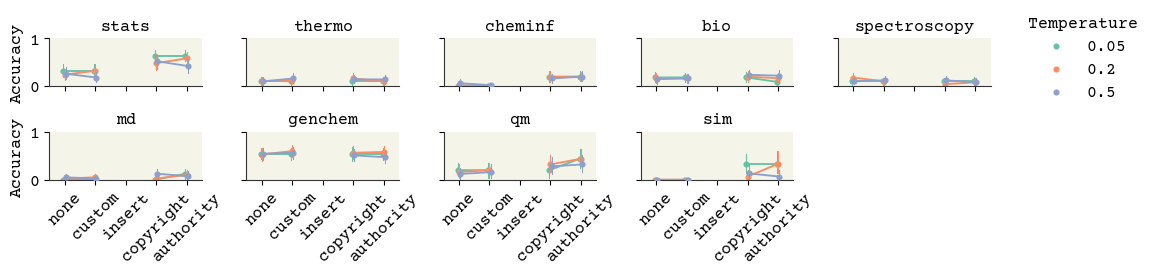

<Figure size 270x270 with 0 Axes>

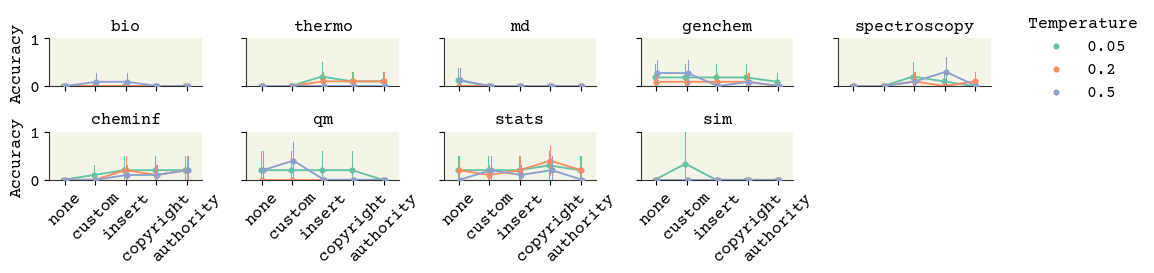

<Figure size 270x270 with 0 Axes>

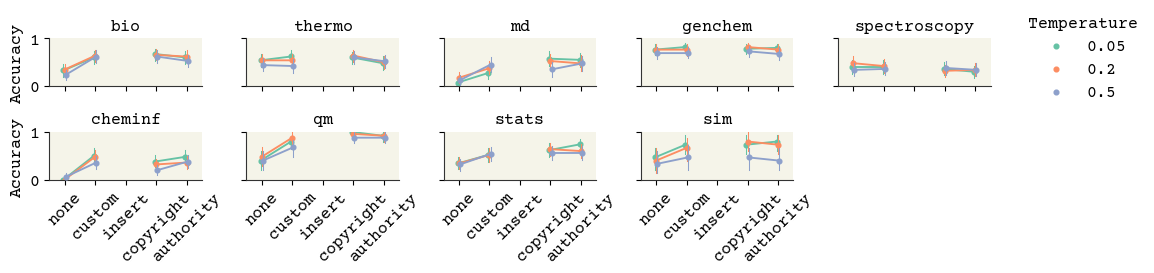

<Figure size 270x270 with 0 Axes>

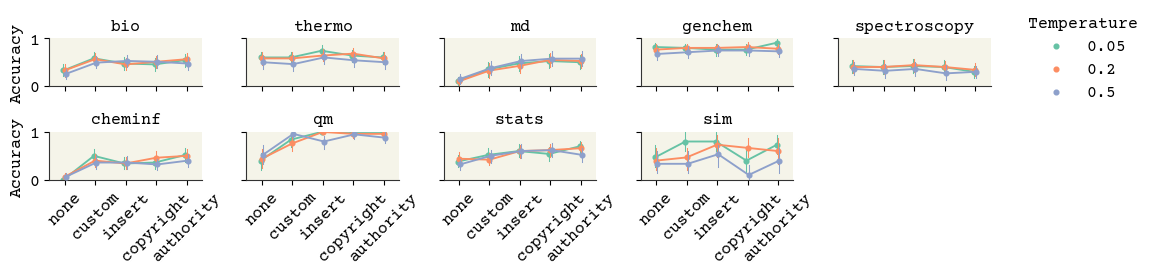

<Figure size 270x270 with 0 Axes>

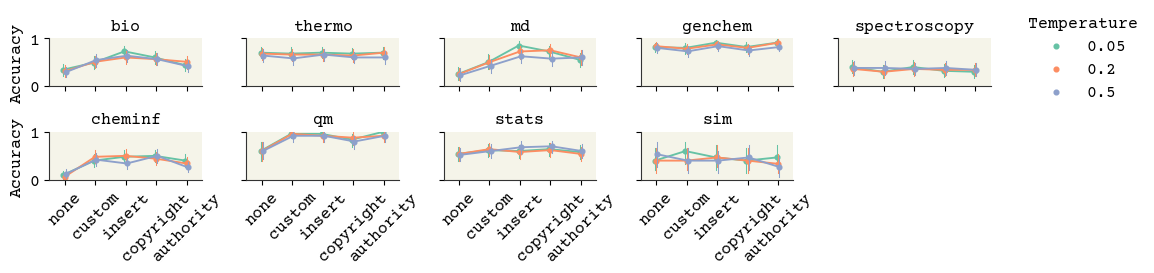

In [143]:
for mn in model_names:
    plt.figure(figsize=(3,3), dpi=90)
    g = sns.FacetGrid(merged[merged.model == mn], col='topic', col_wrap=5, height=1.4, aspect=1.5, hue_order=temperatures)
    g.map(sns.pointplot, 'used_context', 'result', 'temperature', 
          palette='Set2', dodge=True, hue_order=temperatures, order=context_order, scale=0.5, errwidth=0.75)
    g.add_legend(title='Temperature', loc='upper left', bbox_to_anchor=(0.87, 1))
    g.set_axis_labels('', 'Accuracy')    
    g.map(lambda **kwargs: plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45))    
    g.map(lambda **kwargs: plt.gca().set_ylim(0,1))    
    plt.gcf().delaxes(g.axes[-1])
    g.set_titles('{col_name}')
    g.savefig(f'{mn}-accuracy.pdf')
    g.savefig(f'{mn}-accuracy.png', dpi=300)


<Figure size 300x300 with 0 Axes>

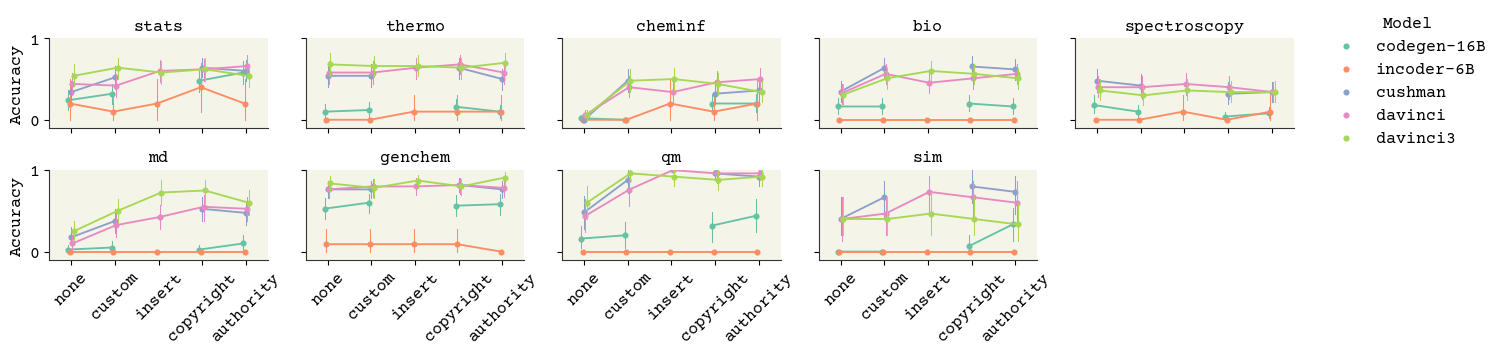

In [170]:
plt.figure(figsize=(3,3))
g = sns.FacetGrid(merged[merged.temperature == 0.2], col='topic', 
                  col_wrap=5, height=1.8, aspect=1.5, hue_order=model_names)
g.map(sns.pointplot, 'used_context', 'result', 'model', hue_order=model_names, order=context_order,
      palette='Set2', dodge=True,  scale=0.5, errwidth=0.75)
g.add_legend(title='Model', loc='upper left', bbox_to_anchor=(0.87, 1))
g.set_axis_labels('', 'Accuracy')
g.map(lambda **kwargs: plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45))
g.map(lambda **kwargs: plt.gca().set_ylim(-0.1,1))    
plt.gcf().delaxes(g.axes[-1])
g.set_titles('{col_name}')
g.savefig('model-comparison.pdf')
g.savefig('model-comparison.png', dpi=300)

In [145]:
print(df.groupby('topic').count().iloc[:,0].to_latex())

\begin{tabular}{lr}
\toprule
{} &  name \\
topic        &       \\
\midrule
bio          &    13 \\
cheminf      &    10 \\
genchem      &    11 \\
md           &    11 \\
plot         &    10 \\
qm           &     8 \\
sim          &     8 \\
spectroscopy &    11 \\
stats        &    11 \\
thermo       &    10 \\
\bottomrule
\end{tabular}



In [146]:
# now remove, because we do not need the plotting dummy
merged = merged[merged.type == 'code']

<Figure size 270x270 with 0 Axes>

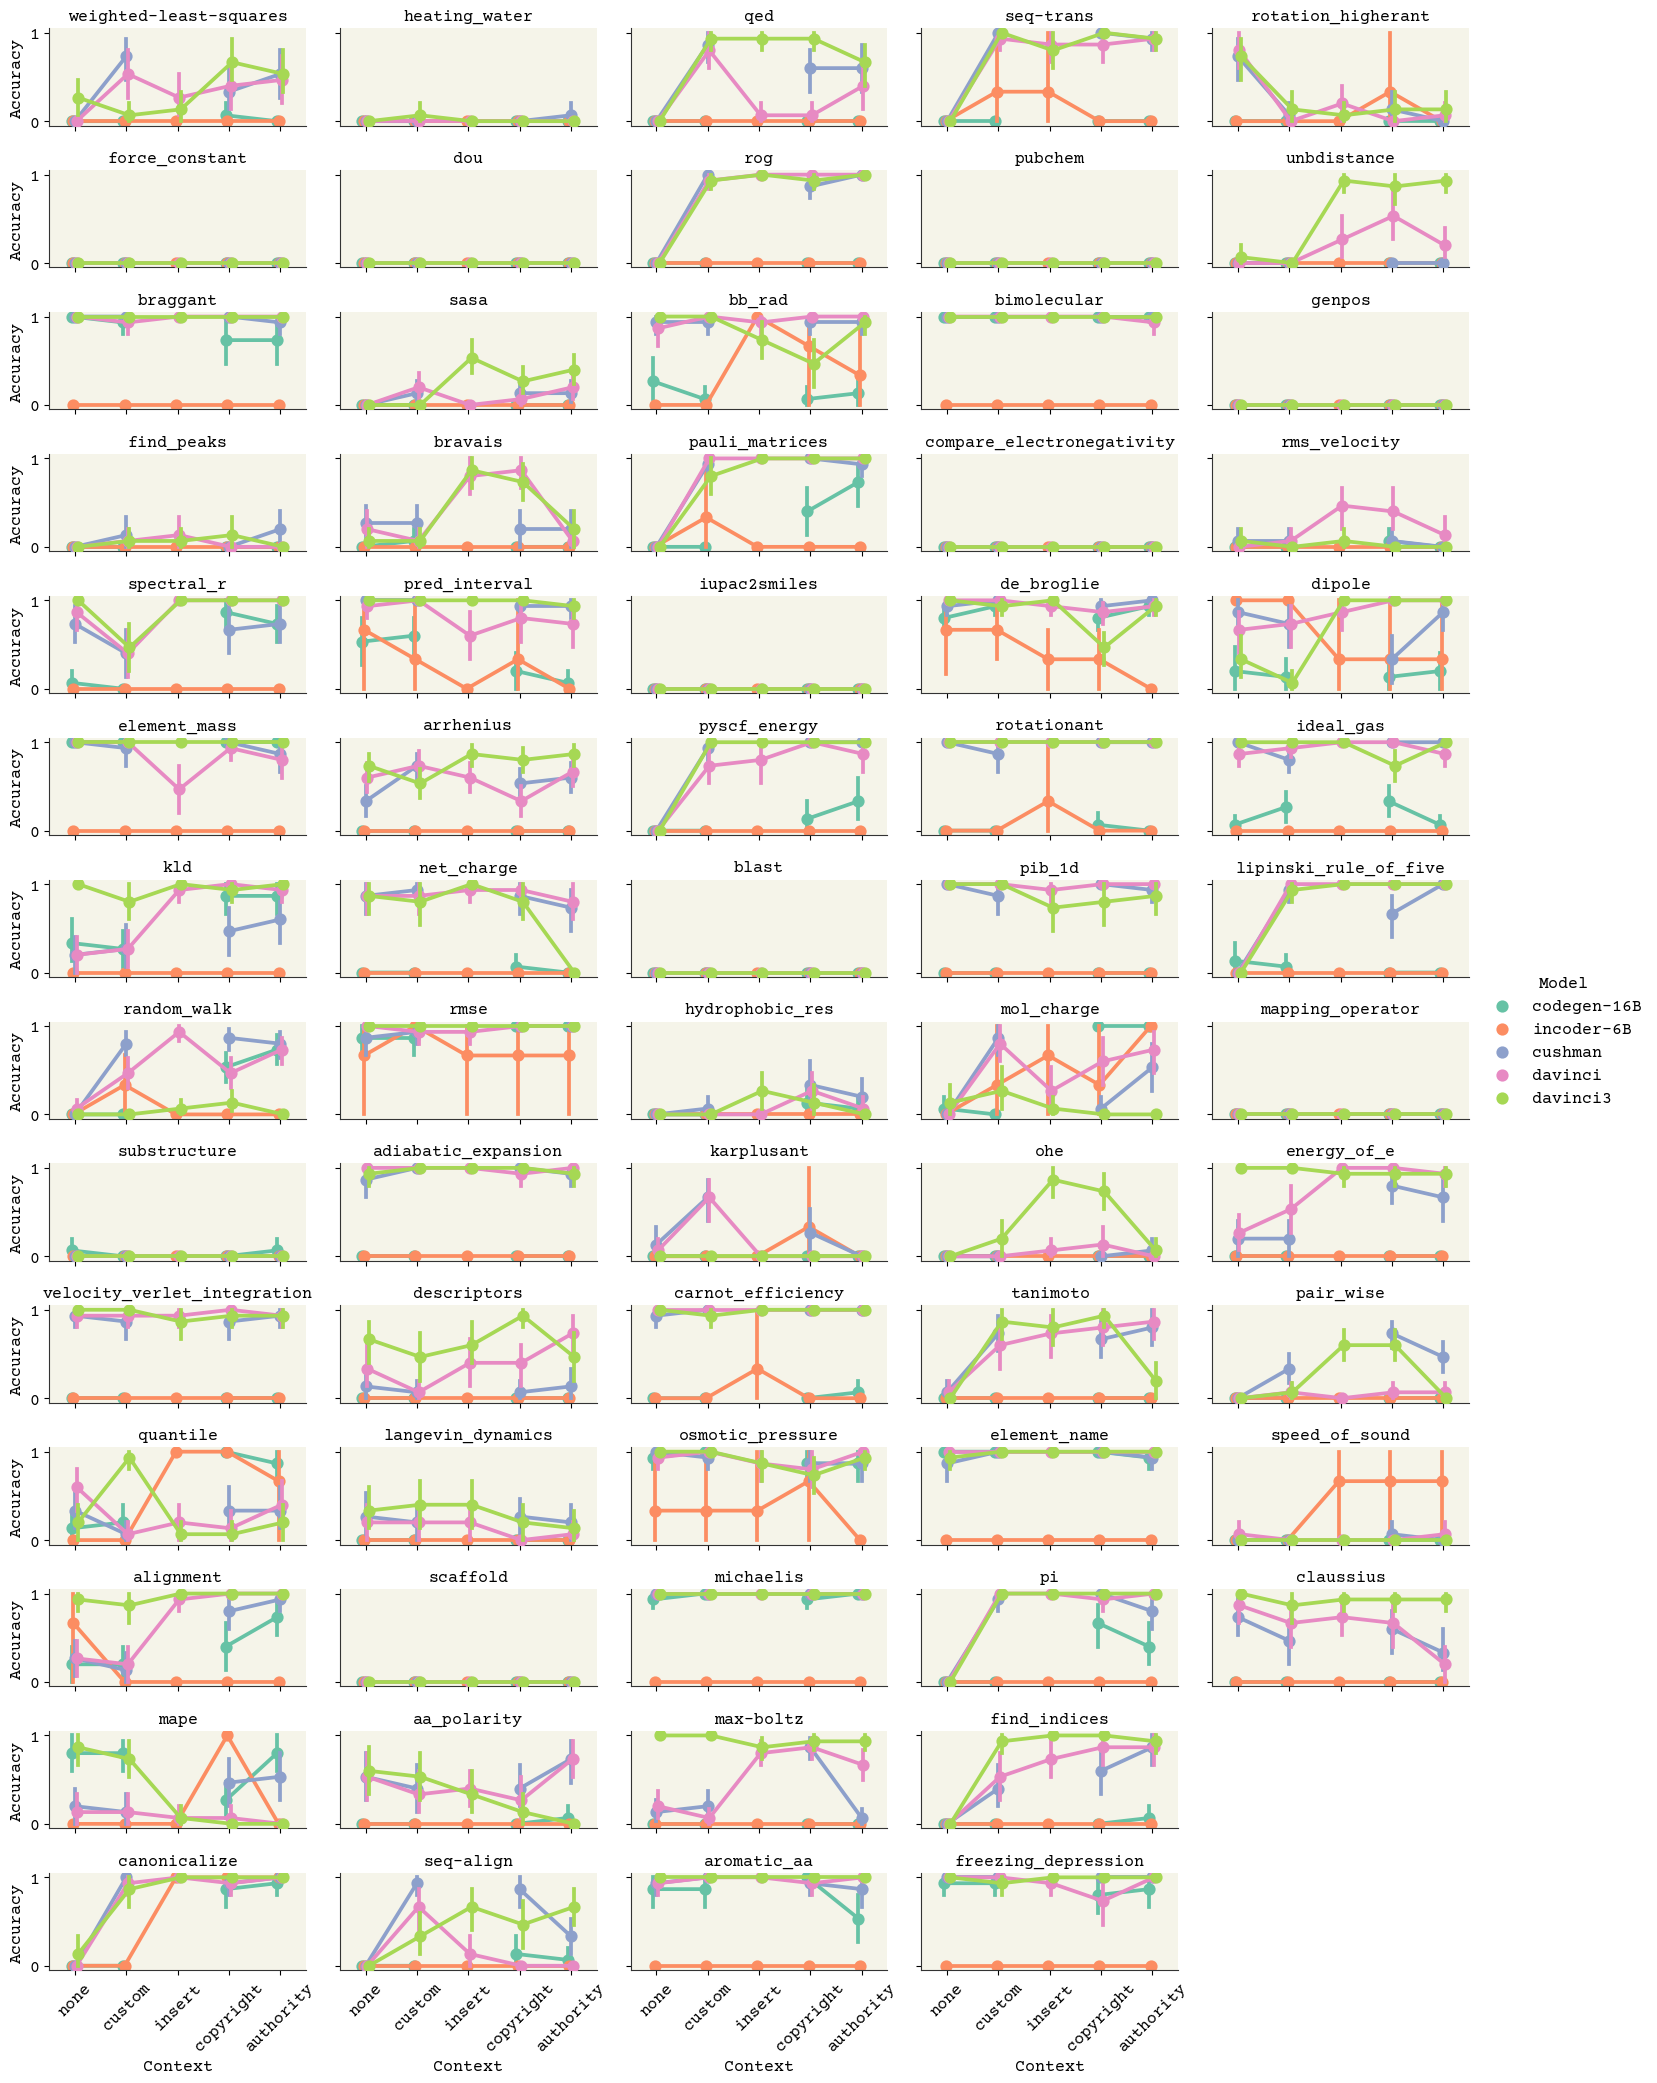

In [147]:
plt.figure(figsize=(3,3), dpi=90)
g = sns.FacetGrid(merged, col='name', col_wrap=5, height=1.5, aspect=2, hue_order=model_names)
g.map(sns.pointplot, 'used_context', 'result', 'model',  hue_order=model_names, order=context_order,
      palette='Set2', dodge=True, fontsize=18)
g.map(lambda **kwargs: plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45))
plt.gcf().delaxes(g.axes[-5])
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
plt.tight_layout()
g.add_legend(title='Model')
g.savefig('all.pdf')
g.savefig('all.png', dpi=300)

In [148]:
print(context_order)

['none', 'custom', 'insert', 'copyright', 'authority']


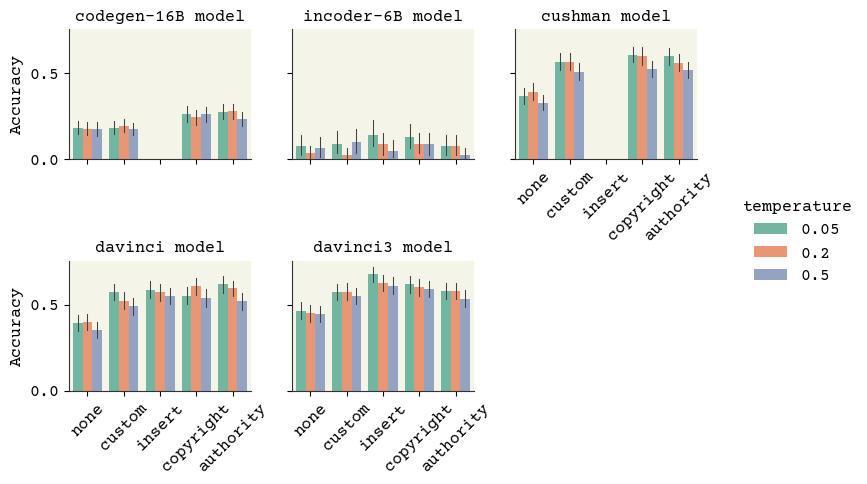

In [158]:
g = sns.catplot(
    data=merged, kind="bar", col="model",
    x="used_context", y="result", hue="temperature",
    palette="Set2", alpha=1, height=2.5, col_wrap=3, order=context_order, errwidth=0.75
)
g.set_axis_labels('', 'Accuracy')
g.map(lambda **kwargs: plt.gca().set_xticklabels(context_order, rotation=45))
g.set_titles('{col_name} model')
g.savefig('context.pdf')
g.savefig('context.png', dpi=300)

In [150]:
print(merged[(merged.model == 'incoder-6B') & (merged.used_context == 'copyright')].\
groupby('name').max().groupby('topic').mean()['result'].to_latex())
print(merged[(merged.model == 'incoder-6B') & (merged.used_context == 'copyright')].\
groupby('name').max().groupby('topic').mean()['result'].mean())

\begin{tabular}{lr}
\toprule
{} &    result \\
topic        &           \\
\midrule
bio          &  0.000000 \\
cheminf      &  0.200000 \\
genchem      &  0.285714 \\
md           &  0.000000 \\
qm           &  0.200000 \\
sim          &  0.000000 \\
spectroscopy &  0.300000 \\
stats        &  0.400000 \\
thermo       &  0.100000 \\
\bottomrule
\end{tabular}

0.16507936507936508


In [151]:
len(merged['name'].unique())

69

In [152]:
print(merged[(merged.model == 'davinci') & (merged.temperature == 0.2) & (merged.used_context == 'insert')].\
groupby('name').max().groupby('topic').mean()['result'].to_latex())
print(merged[(merged.model == 'davinci')& (merged.temperature == 0.2) & (merged.used_context == 'insert')].\
groupby('name').max().groupby('topic').mean()['result'].mean())

\begin{tabular}{lr}
\toprule
{} &    result \\
topic        &           \\
\midrule
bio          &  0.428571 \\
cheminf      &  0.500000 \\
genchem      &  0.857143 \\
md           &  0.625000 \\
qm           &  1.000000 \\
sim          &  1.000000 \\
spectroscopy &  0.500000 \\
stats        &  0.700000 \\
thermo       &  0.800000 \\
\bottomrule
\end{tabular}

0.7123015873015873


In [153]:
print(merged[(merged.model == 'davinci3') & (merged.temperature == 0.2) & (merged.used_context == 'insert')].\
groupby('name').max().groupby('topic').mean()['result'].to_latex())
print(merged[(merged.model == 'davinci3')& (merged.temperature == 0.2) & (merged.used_context == 'insert')].\
groupby('name').max().groupby('topic').mean()['result'].mean())

\begin{tabular}{lr}
\toprule
{} &    result \\
topic        &           \\
\midrule
bio          &  0.857143 \\
cheminf      &  0.500000 \\
genchem      &  0.857143 \\
md           &  0.875000 \\
qm           &  1.000000 \\
sim          &  1.000000 \\
spectroscopy &  0.400000 \\
stats        &  0.600000 \\
thermo       &  0.700000 \\
\bottomrule
\end{tabular}

0.7543650793650793


In [157]:
print(merged[(merged.model == 'codegen-16B') & (merged.temperature == 0.2) & (merged.used_context == 'authority')].\
groupby('name').max().groupby('topic').mean()['result'].to_latex())
print(merged[(merged.model == 'codegen-16B')& (merged.temperature == 0.2) & (merged.used_context == 'authority')].\
groupby('name').max().groupby('topic').mean()['result'].mean())

\begin{tabular}{lr}
\toprule
{} &    result \\
topic        &           \\
\midrule
bio          &  0.000000 \\
cheminf      &  0.200000 \\
genchem      &  0.714286 \\
md           &  0.125000 \\
qm           &  0.600000 \\
sim          &  0.000000 \\
spectroscopy &  0.100000 \\
stats        &  0.700000 \\
thermo       &  0.100000 \\
\bottomrule
\end{tabular}

0.28214285714285714
